In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats


In [113]:
recomb_file = '../recombination_rate/wgs'
kfolds = 5
lambs = ['1', '10', '100', '10000', '100000', '1000000', '1e+07']
cutoff = 10**-11

In [114]:
all_positions = []
with open('%s.positions.txt' % (recomb_file), 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        all_positions.append((pieces[0], int(pieces[1])))

lengths = np.hstack(([0 if all_positions[i][0] != all_positions[i+1][0] else all_positions[i+1][1]-all_positions[i][1] for i in range(len(all_positions)-1)], 0))

#lengths = np.load('%s.lengths.npy' % recomb_file)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


Maternal
genome in hotspot 0.9793576619003503
train crossovers in hotspot 0.9999643208271225
test crossovers in hotspot 0.9998914459400782


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in true_divide


Paternal
genome in hotspot 0.9811293823672788
train crossovers in hotspot 1.0
test crossovers in hotspot 1.0


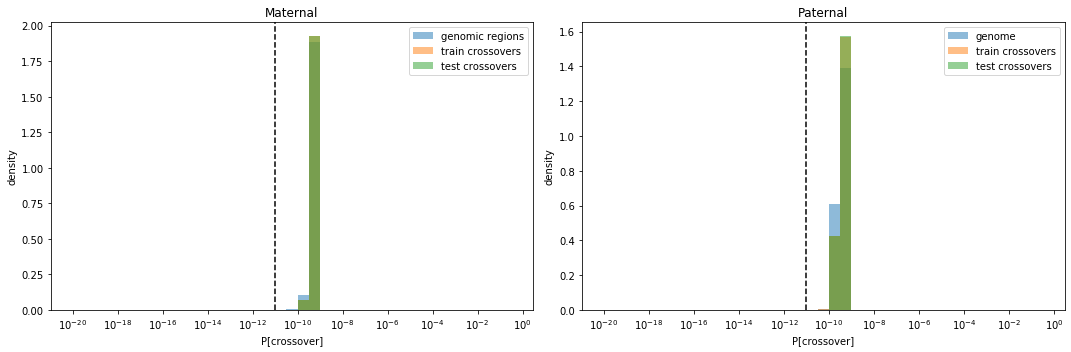

In [115]:
plt.figure(figsize=(15, 5))

bins = np.arange(-20, 0, 0.5)
k = 0
lamb = lambs[-1]

plt.subplot(1, 2, 1)
#co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%.0f.%d.npy' % (recomb_file, lamb, k))

X_mat_train = sparse.load_npz('%s.X_mat_train.%s.%d.npz' % (recomb_file, lamb, k))
X_mat_test = sparse.load_npz('%s.X_mat_test.%s.%d.npz' % (recomb_file, lamb, k))

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genomic regions')
is_hotspot_mat = (ps_mat/lengths > cutoff)
    
co_ps_mat_train = X_mat_train.dot(ps_mat)
co_lengths_mat_train = X_mat_train.dot(lengths)
co_ps_mat_test = X_mat_test.dot(ps_mat)
co_lengths_mat_test = X_mat_test.dot(lengths)

print('Maternal')
print('genome in hotspot', (ps_mat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_mat_train/co_lengths_mat_train > cutoff)/len(co_ps_mat_train))
print('test crossovers in hotspot', np.sum(co_ps_mat_test/co_lengths_mat_test > cutoff)/len(co_ps_mat_test))
    
plt.hist(np.clip(np.log10(co_ps_mat_train) - np.log10(co_lengths_mat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_mat_test) - np.log10(co_lengths_mat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
#co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%.0f.%d.npy' % (recomb_file, lamb, k))
    
X_pat_train = sparse.load_npz('%s.X_pat_train.%s.%d.npz' % (recomb_file, lamb, k))
X_pat_test = sparse.load_npz('%s.X_pat_test.%s.%d.npz' % (recomb_file, lamb, k))
    
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genome')

co_ps_pat_train = X_pat_train.dot(ps_pat)
co_lengths_pat_train = X_pat_train.dot(lengths)
co_ps_pat_test = X_pat_test.dot(ps_pat)
co_lengths_pat_test = X_pat_test.dot(lengths)
 
print('Paternal')
print('genome in hotspot', (ps_pat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_pat_train/co_lengths_pat_train > cutoff)/len(co_ps_pat_train))
print('test crossovers in hotspot', np.sum(co_ps_pat_test/co_lengths_pat_test > cutoff)/len(co_ps_pat_test))

plt.hist(np.clip(np.log10(co_ps_pat_train) - np.log10(co_lengths_pat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_pat_test) - np.log10(co_lengths_pat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10


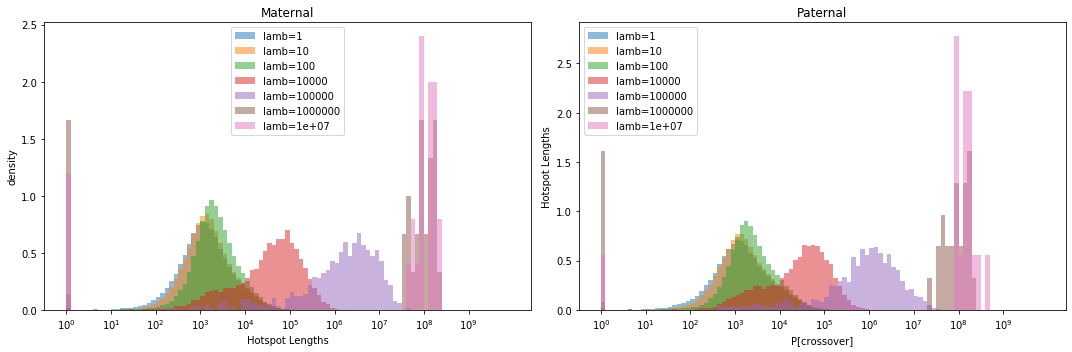

In [117]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for lamb in lambs:
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_mat = (ps_mat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1, np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
    if is_hotspot_mat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_mat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_mat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 9), alpha=0.5, bins=np.arange(0, 10, 0.1), density=True, label='lamb=%s' % lamb)

plt.title('Maternal')
plt.xlabel('Hotspot Lengths')
plt.ylabel('density')
plt.xticks(np.arange(0, 10), ['$10^{%d}$' % x for x in np.arange(0, 10)])
plt.legend()

plt.subplot(1, 2, 2)
for lamb in lambs:   
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_pat = (ps_pat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1, np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
    if is_hotspot_pat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_pat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_pat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 9), alpha=0.5, bins=np.arange(0, 10, 0.1), density=True, label='lamb=%s' % lamb)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(0, 10), ['$10^{%d}$' % x for x in np.arange(0, 10)])
plt.ylabel('Hotspot Lengths')
plt.legend()  

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


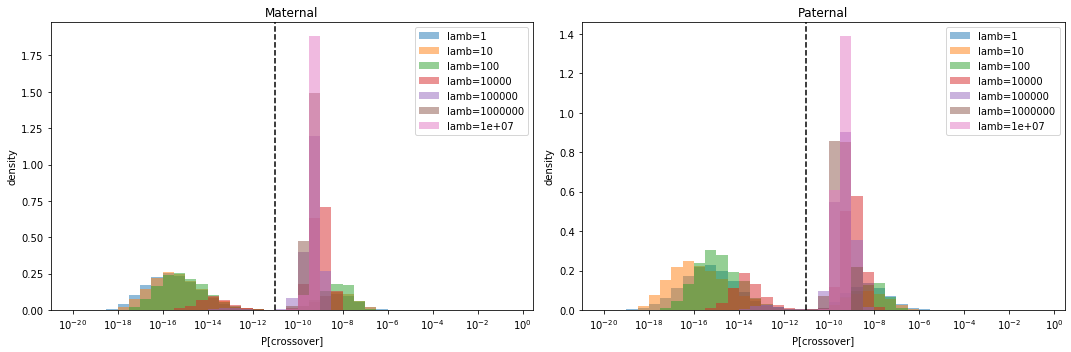

In [118]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for lamb in lambs:
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='lamb=%s' % lamb)

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
for lamb in lambs:   
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='lamb=%s' % lamb)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

[3.41854102e-06 6.89716041e-07 8.76621547e-07 ... 6.25837530e-07
 1.59941177e-05 2.97142321e-10] [6.37469118e-06 1.28612203e-06 1.63461414e-06 ... 1.06588000e-06
 2.72399981e-05 3.75621251e-10]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


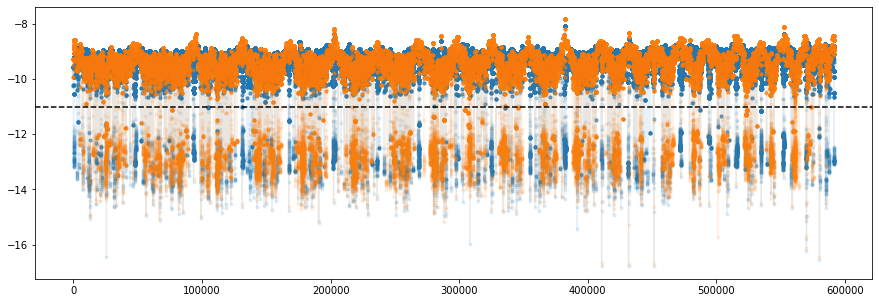

In [119]:
chrom = '20'
lamb = 100000
k = 0

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
print(ps_mat, ps_pat)

plt.figure(figsize=(15, 5))
indices = [c==chrom for c, p in all_positions]
#p = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
#         np.repeat((np.log10(ps_mat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
#indices = [c==chrom for c, p in all_positions]
#q = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
#         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)

plt.plot(np.log10(ps_mat)-np.log10(lengths), alpha=0.1, marker='.')
plt.plot(np.log10(ps_pat)-np.log10(lengths), alpha=0.1, marker='.')
plt.axhline(-11, color='black', linestyle='--')

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

#plt.xlim([0, 1000000])
plt.show()


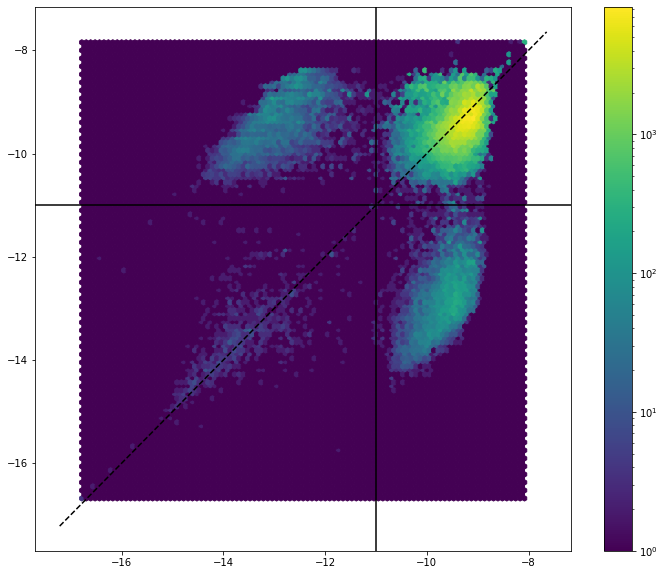

In [120]:
lamb = 100000
k = 0

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))

plt.figure(figsize=(12, 10))
plt.hexbin(np.clip(np.log10(ps_mat[lengths!=0]) - np.log10(lengths[lengths!=0]), -20, 0), 
            np.clip(np.log10(ps_pat[lengths!=0]) - np.log10(lengths[lengths!=0]), -20, 0),
          gridsize=100, bins='log')#, marker='.', alpha=0.1)
plt.colorbar()
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(np.log10(cutoff), color='black')
plt.axvline(np.log10(cutoff), color='black')
plt.show()

In [124]:
genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot = np.zeros((len(lambs), kfolds)), np.zeros((len(lambs), kfolds)), np.zeros((len(lambs), kfolds))
co_in_hotspot_mat_train, co_in_hotspot_pat_train = np.zeros((len(lambs), kfolds)), np.zeros((len(lambs), kfolds))
co_in_hotspot_mat_test, co_in_hotspot_pat_test = np.zeros((len(lambs), kfolds)), np.zeros((len(lambs), kfolds))

for i, lamb in enumerate(lambs):
    for k in range(kfolds):
        X_mat_train = sparse.load_npz('%s.X_mat_train.%s.%d.npz' % (recomb_file, lamb, k))
        X_mat_test = sparse.load_npz('%s.X_mat_test.%s.%d.npz' % (recomb_file, lamb, k))

        ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
        is_mat_hotspot = (ps_mat/lengths > cutoff)
        
        co_ps_mat_train = X_mat_train.dot(ps_mat)
        co_lengths_mat_train = X_mat_train.dot(lengths)
        co_ps_mat_test = X_mat_test.dot(ps_mat)
        co_lengths_mat_test = X_mat_test.dot(lengths)

        genome_in_hotspot_mat[i, k] = is_mat_hotspot.dot(lengths)/np.sum(lengths)
        #co_in_hotspot_mat_train[i, k] = np.sum(co_ps_mat_train/co_lengths_mat_train > cutoff)/len(co_ps_mat_train)
        #co_in_hotspot_mat_test[i, k] = np.sum(co_ps_mat_test/co_lengths_mat_test > cutoff)/len(co_ps_mat_test)
        #co_in_hotspot_mat_train[i, k] = np.median(np.log(co_ps_mat_train))
        #co_in_hotspot_mat_test[i, k] = np.median(np.log(co_ps_mat_test))
        co_in_hotspot_mat_train[i, k] = np.sum(np.log(co_ps_mat_train))
        co_in_hotspot_mat_test[i, k] = np.sum(np.log(co_ps_mat_test))
        #co_in_hotspot_mat_train[i, k] = stats.binom_test(np.sum(X_mat_train.dot(is_mat_hotspot)>0), len(co_ps_mat_train), p=genome_in_hotspot_mat[i, k])
        #co_in_hotspot_mat_test[i, k] = stats.binom_test(np.sum(X_mat_test.dot(is_mat_hotspot)>0), len(co_ps_mat_test), p=genome_in_hotspot_mat[i, k])
        #co_in_hotspot_mat_train[i, k] = np.sum(X_mat_train.dot(is_mat_hotspot)>0)*np.log(genome_in_hotspot_mat[i, k]) \
        #                                + np.sum(X_mat_train.dot(is_mat_hotspot)==0)*np.log(1-genome_in_hotspot_mat[i, k])
        #co_in_hotspot_mat_test[i, k] = np.sum(X_mat_test.dot(is_mat_hotspot)>0)*np.log(genome_in_hotspot_mat[i, k]) \
        #                                + np.sum(X_mat_test.dot(is_mat_hotspot)==0)*np.log(1-genome_in_hotspot_mat[i, k])
        
        X_pat_train = sparse.load_npz('%s.X_pat_train.%s.%d.npz' % (recomb_file, lamb, k))
        X_pat_test = sparse.load_npz('%s.X_pat_test.%s.%d.npz' % (recomb_file, lamb, k))

        ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
        is_pat_hotspot = (ps_pat/lengths > cutoff)
        
        co_ps_pat_train = X_pat_train.dot(ps_pat)
        co_lengths_pat_train = X_pat_train.dot(lengths)
        co_ps_pat_test = X_pat_test.dot(ps_pat)
        co_lengths_pat_test = X_pat_test.dot(lengths)

        genome_in_hotspot_pat[i, k] = is_pat_hotspot.dot(lengths)/np.sum(lengths)
        #co_in_hotspot_pat_train[i, k] = np.sum(co_ps_pat_train/co_lengths_pat_train > cutoff)/len(co_ps_pat_train)
        #co_in_hotspot_pat_test[i, k] = np.sum(co_ps_pat_test/co_lengths_pat_test > cutoff)/len(co_ps_pat_test)
        #co_in_hotspot_pat_train[i, k] = np.median(np.log(co_ps_pat_train))
        #co_in_hotspot_pat_test[i, k] = np.median(np.log(co_ps_pat_test))
        co_in_hotspot_pat_train[i, k] = np.sum(np.log(co_ps_pat_train))
        co_in_hotspot_pat_test[i, k] = np.sum(np.log(co_ps_pat_test))
        #co_in_hotspot_pat_train[i, k] = stats.binom_test(np.sum(X_pat_train.dot(is_pat_hotspot)>0), len(co_ps_pat_train), p=genome_in_hotspot_pat[i, k])
        #co_in_hotspot_pat_test[i, k] = stats.binom_test(np.sum(X_pat_test.dot(is_pat_hotspot)>0), len(co_ps_pat_test), p=genome_in_hotspot_pat[i, k])
        #co_in_hotspot_pat_train[i, k] = np.sum(X_pat_train.dot(is_mat_hotspot)>0)*np.log(genome_in_hotspot_pat[i, k]) \
        #                                + np.sum(X_pat_train.dot(is_mat_hotspot)==0)*np.log(1-genome_in_hotspot_pat[i, k])
        #co_in_hotspot_pat_test[i, k] = np.sum(X_pat_test.dot(is_mat_hotspot)>0)*np.log(genome_in_hotspot_pat[i, k]) \
        #                                + np.sum(X_pat_test.dot(is_mat_hotspot)==0)*np.log(1-genome_in_hotspot_pat[i, k])
        
        genome_in_hotspot[i, k] = (is_mat_hotspot & is_pat_hotspot).dot(lengths)/np.sum(lengths)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log


[0.10412074 0.10640827 0.12090676 0.4630904  0.87379762 0.95803247
 0.98032432]
[0.09148208 0.09352189 0.10383209 0.36039913 0.82103844 0.95707578
 0.98094913]
[0.01877431 0.0195886  0.0245731  0.23730437 0.77131596 0.95595206
 0.98013485]
[-2717959.45584291 -2721068.69133928 -2739280.74443558 -3071912.26882828
 -3267027.46033338 -3347558.30264917 -3384170.35609477]
[-1709936.96621652 -1711834.97996414 -1724516.44203957 -1955457.24879089
 -2105229.46582782 -2156124.92919354 -2185458.90359706]
[-431183.05301864 -426113.25386964 -406590.5801429  -368125.02428357
 -365630.39766971 -369575.96413602 -374566.05671941]
[            -inf -277787.26599106 -261299.67586229 -240817.56473799
 -236967.87294052 -238962.80072337 -241810.66420486]


//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


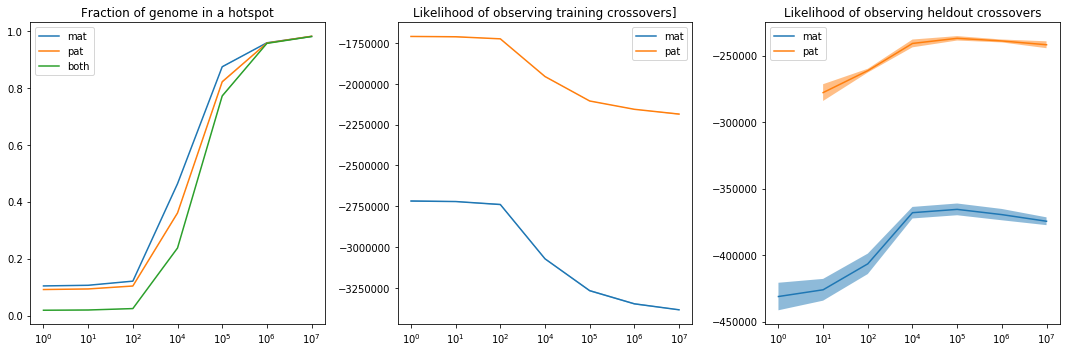

In [125]:
def plot_with_confidence(data, label):
    print(np.mean(data, axis=1))
    plt.plot(np.mean(data, axis=1), label=label)
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.mean(data, axis=1), scale=stats.sem(data, axis=1)) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(np.arange(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_with_confidence(genome_in_hotspot_mat, 'mat')
plot_with_confidence(genome_in_hotspot_pat, 'pat')
plot_with_confidence(genome_in_hotspot, 'both')
plt.title('Fraction of genome in a hotspot')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(1, 3, 2)
plot_with_confidence(co_in_hotspot_mat_train, 'mat')
plot_with_confidence(co_in_hotspot_pat_train, 'pat')
plt.title('Likelihood of observing training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(1, 3, 3)
plot_with_confidence(co_in_hotspot_mat_test, 'mat')
plot_with_confidence(co_in_hotspot_pat_test, 'pat')
plt.title('Likelihood of observing heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.tight_layout()
plt.show()

In [126]:
print(lambs[np.argmax(np.mean(co_in_hotspot_mat_test, axis=1))])
print(lambs[np.argmax(np.mean(co_in_hotspot_pat_test, axis=1))])

100000
100000
